# Part 6. Production Model Evaluation

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

# Library to save the model
import pickle

## Importing datasets

In [2]:
def read_train_test(status='train'):
    # Function to select dataset to read
    if status == 'train':
        df = pd.read_csv('../datasets/train_cleaned.csv')
    elif status == 'test':
        df = pd.read_csv('../datasets/test_cleaned.csv')
    else:
        print(f"Select the correct dataset")
    return df

In [3]:
# Select 'train' to read train.csv
# Select 'test' to read test.csv
df = read_train_test('train')

In [4]:
# View head
df.head(5)

,ms_zoning,lot_frontage,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,condition_1,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
0,Res,80.0,1,1,1,AllPub,Corner,1,SawyerW,N,...,159000,0,2436.0,1,1.5,1,0,0,11.976659,9.170039
1,Res,90.0,1,0,1,AllPub,CulDSac,1,SawyerW,N,...,271900,0,4354.0,1,2.0,1,1,1,12.513190,9.594514
2,Res,60.0,1,0,1,NoSeWa,CulDSac,1,Timber,N,...,137500,0,2163.0,1,1.5,1,1,0,11.831379,9.573246
3,Res,48.0,1,1,1,AllPub,Inside,1,NridgHt,N,...,248500,0,2907.0,1,2.0,1,1,1,12.423198,8.775240
4,Res,61.0,1,0,1,AllPub,Inside,1,Gilbert,R,...,167000,1,1758.0,1,2.5,0,0,0,12.025749,9.183380


# Run model to check numerical model

#### Create function to run linear regression

In [5]:
def linreg_log(X,y,t_s=0.2,log=False):
    # model to train data - with selection of training with ln-y or y
    
    # train test split and instantiate
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=t_s,random_state=42)
    lr = LinearRegression()
    
    if log == True:
        # flow to train with ln-y
        
        # transform y to ln
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)
        
        # fit model to ln(y)
        lr.fit(X_train,y_train_log)
        
        # predict train and test
        y_train_pred_log = lr.predict(X_train)
        y_test_pred_log = lr.predict(X_test)
        
        # exponential transform ln(y) back to y
        y_train_preds = np.exp(y_train_pred_log)
        y_test_preds = np.exp(y_test_pred_log)
        
        # print model name
        print()
        print(" Production Model ".center(30, "="))
        
        # train test R^2 scores
        train_r2 = lr.score(X_train,y_train_log)
        test_r2 = lr.score(X_test,y_test_log)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train_log)
        
    else:
        
        # fit model to y
        lr.fit(X_train,y_train)
        
        # predict train and test y
        y_train_preds = lr.predict(X_train)
        y_test_preds = lr.predict(X_test)
        
        # print model name
        print()
        print(" Production Model ".center(30, "="))
        
        # train test score
        train_r2 = lr.score(X_train,y_train)
        test_r2 = lr.score(X_test,y_test)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train)

    # metrics (comparing y_preds with y)
    rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
    rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)
    
    # print model scores
    print()
    print(f"train r2: {train_r2.round(4)}")
    print(f"test_r2: {test_r2.round(4)}")
    print(f"mean cross val: {mean_cross_val.round(4)}")
    print(f"train rmse: {rmse_train}")
    print(f"test rmse: {rmse_test}")
    
    # create plots of predictions vs true values - to help visualize model performance
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    # correlation calculation
    cor = np.corrcoef(y_test,y_test_preds)
    
    # scatter plot (left) of y_test vs y_test_preds
    plot1 = sns.scatterplot(ax=axes[0],x=y_test,y=y_test_preds)
    sns.lineplot(ax=axes[0],x=y_test,y=y_test)
    plot1.set_xlabel('y_test')
    plot1.set_ylabel('y_test_preds')
    plot1.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})")
    
    # histogram (right) of y_test vs y_test_preds
    plot2 = sns.histplot(ax=axes[1],x=y_test,color='grey',alpha=0.5)
    plot2 = sns.histplot(ax=axes[1],x=y_test_preds)
    plot2.set_xlabel('log_sale_price');
    
    return y_test,y_test_preds

#### Selected Production Model - Tuning 4: Numerical + Categorical (Quality Related Columns)

In [6]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality']

In [7]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [8]:
# Combine columns
cols = num_cols + cat_cols

In [9]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [10]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)

In [11]:
X.columns

Index(['overall_quality', 'total_sf', 'garage_cars', 'total_bath',
       'year_built', 'has_fireplace', 'total_rooms_above_ground',
       'has_open_porch', 'masonry_area', 'log_lot_area', 'lot_frontage',
       'has_wood_deck', 'central_air', 'has_basement_sf',
       'bedroom_above_ground', 'functional', 'street', 'has_2nd_floor_sf',
       'month_sold', 'year_sold', 'lot_contour', 'lot_slope',
       'overall_condition', 'kitchen_above_ground', 'lot_shape',
       'external_quality_Fa', 'external_quality_Gd', 'external_quality_TA',
       'basement_quality_E', 'basement_quality_G', 'basement_quality_O',
       'heating_quality_Fa', 'heating_quality_Gd', 'heating_quality_TA',
       'kitchen_quality_Gd', 'kitchen_quality_Ta', 'fireplace_quality_Fa',
       'fireplace_quality_Gd', 'fireplace_quality_None',
       'fireplace_quality_Po', 'fireplace_quality_TA', 'garage_quality_G',
       'garage_quality_O'],
      dtype='object')


====== Production Model ======

train r2: 0.9226
test_r2: 0.9167
mean cross val: [0.9299 0.8952 0.9033 0.925  0.9095]
train rmse: 19704.42
test rmse: 21084.5


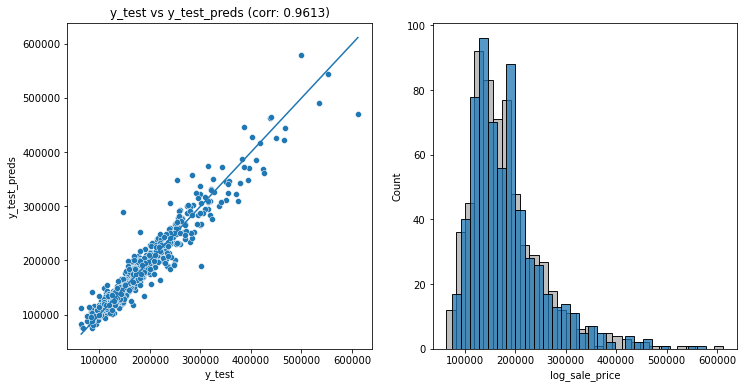

In [12]:
# Testing the model
y_test,y_test_preds = linreg_log(X,y,0.3,True)

## Evaluation

Upon iterating many different models from selecting only numerical columns to select 10-12 categorical columns. This is our optimal production suitable model for the following reasons.

__1. Numerical Columns:__
- This model is a simplified version numerical columns
- Keeping all cleaned numerical featurs perform better than selecting only a few correlated features
- This is because fitting the model calculates the best coefficients to make use of all our features
- Note that is only works if the dataset has been cleaned to a certain degree

__2. Categorical Columns:__
- This model selects only generic categorical columns (i.e. quality related columns)
- This avoids overfitting in the future since they're columns that all houses should have
- These selected categorical columns has acceptable distribution of values
- Allowing us to train the model without overfitting

__3. Metrics:__
- Comparing the R^2 values of both the training and testing datasets shows slight difference
- Cross validation also shows extremely small differences in R2 for all 5 sets
- Overfitting is unlikely in this case
- The RMSE of the train data is very low and the RMSE of the test data is within acceptable range
- Meaning this model performs well while being unlikely to overfit in the future